<div style="text-align: center;">
  <span style="font-size: 24px; font-weight: bold;">Model Comparative analysis</span>
</div>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Through the previous analysis, we have obtained the results of model ConvBiGRU. In this document, I will train other models and conduct a comparative analysis with model ConvBiGRU to identify the advantages of model ConvBiGRU and the directions for improvement
</span>

<span style="font-size:22px;font-weight:bold"> 1.Use of python libraries </span>

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize  # 导入 winsorize
from pandas.errors import PerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=PerformanceWarning)

<span style="font-size:22px;font-weight:bold"> 2.Data Processing </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This part is the same as the content of the data processing file and will not be introduced again.
</span>

In [3]:
def winsorize_dataframe(df: pd.DataFrame, numeric_cols: list, limits: list = [0.01, 0.01]) -> pd.DataFrame:
    df_copy = df.copy()  # 创建 DataFrame 的副本，以避免修改原始 DataFrame
    for col in numeric_cols:
        df_copy[col] = winsorize(df_copy[col], limits=limits)
    return df_copy

In [4]:
def prepare_unsupervised_time_series_data(
        file_path, seq_length,
        scaler=None, return_labels=False):
    try:
        df = pd.read_csv(file_path)
        print(f"成功加载：{file_path}")
    except FileNotFoundError:
        print(f"文件未找到：{file_path}")
        return None, None, None

    has_label = 'label' in df.columns
    if has_label:
        raw_labels = df['label'].values
        df = df.drop(columns=['label'])
    else:
        raw_labels = None

    # 数值列、缺失值填充、去重
    num_cols = df.select_dtypes(include=np.number).columns
    df_num  = df[num_cols].fillna(df[num_cols].mean()).drop_duplicates()

    # 标准化
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df_num)
        print("已 fit_transform 标准化。")
    else:
        data_scaled = scaler.transform(df_num)
        print("已 transform 标准化。")

    # 滑动窗口 + 可选标签窗口
    X, Y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i+seq_length])
        if return_labels and raw_labels is not None:
            # 窗口内任一点为异常则视为异常窗口
            Y.append(int(raw_labels[i:i+seq_length].any()))
    X = np.array(X)
    Y = np.array(Y) if Y else None

    print(f"生成窗口数：{X.shape[0]}, 序列长：{seq_length}, 特征数：{X.shape[2]}")
    return X, scaler, Y

In [13]:
def add_features(df: pd.DataFrame, seq_length: int, numeric_cols: list) -> pd.DataFrame:
    for col in numeric_cols:
        df[f'{col}_diff1'] = df[col].diff().fillna(0)
        df[f'{col}_diff2'] = df[f'{col}_diff1'].diff().fillna(0)

    # 滑动统计特征
    for col in numeric_cols:
        df[f'{col}_roll_mean'] = (
            df[col]
              .rolling(seq_length)
              .mean()
              .fillna(method='bfill')
        )
        df[f'{col}_roll_std'] = (
            df[col]
              .rolling(seq_length)
              .std()
              .fillna(method='bfill')
        )

    # 频域主频特征（只示例第一个 numeric_cols）
    def dominant_freq(x: np.ndarray) -> float:
        fft_vals = np.fft.rfft(x)
        mags     = np.abs(fft_vals)
        freqs    = np.fft.rfftfreq(len(x))
        return float(freqs[np.argmax(mags)])

    df[f'{numeric_cols[0]}_dom_freq'] = (
        df[numeric_cols[0]]
          .rolling(seq_length)
          .apply(dominant_freq, raw=True)
          .fillna(method='bfill')
    )

    return df

In [7]:
def prepare_data_with_features(
        file_path: str,
        seq_length: int,
        scaler: StandardScaler = None,
        return_labels: bool = False,
        winsorize_clip: bool = False  # 添加 winsorize_clip 参数
    ):
    # 1. 读取 CSV
    df = pd.read_csv(file_path)
    raw_labels = None
    if 'label' in df.columns:
        raw_labels = df['label'].values
        df = df.drop(columns=['label'])

    # 2. 保留数值列，填充缺失
    df = df.select_dtypes(include=np.number)
    df = df.fillna(method='ffill').fillna(method='bfill')

    # 3. 特征工程
    numeric_cols = df.columns.tolist()
    df = add_features(df, seq_length, numeric_cols)

    # 4. Winsorize 处理 (在标准化之前)
    if winsorize_clip:
        df = winsorize_dataframe(df, numeric_cols)  # 调用新的 winsorize_dataframe 函数

    # 5. 标准化
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(df)
    else:
        data_scaled = scaler.transform(df)

    # 6. 滑动窗口切分
    X, Y = [], []
    n = data_scaled.shape[0]
    for i in range(n - seq_length):
        X.append(data_scaled[i:i+seq_length])
        if return_labels and raw_labels is not None:
            Y.append(int(raw_labels[i:i+seq_length].any()))
    X = np.array(X)
    Y = np.array(Y) if return_labels and raw_labels is not None else None

    return X, scaler, Y

<span style="font-size:22px;font-weight:bold"> 3.LSTM-AE </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An LSTM Autoencoder is a type of neural network architecture specifically designed for unsupervised learning on sequential data. It combines the sequence-handling capabilities of Long Short-Term Memory (LSTM) networks with the dimensionality reduction and feature learning structure of an Autoencoder. The model comprises an LSTM encoder, which processes an input sequence and compresses it into a lower-dimensional latent representation, and an LSTM decoder, which attempts to reconstruct the original sequence from this latent representation. By training the network to minimize the difference between the input and the reconstructed output, it learns to capture the key temporal patterns and structure within the data, making it particularly useful for tasks like sequential anomaly detection, data denoising, and representation extraction for time series data.
</span>

<span style="font-size:18px;font-weight:bold"> 3.1 Hyperparameters and Paths </span>

In [8]:
# --- Hyperparameters & Paths ---
seq_length = 20
hidden_dim = 64        # Hidden size for LSTM AE
num_layers = 2
dropout = 0.2
lr = 1e-3
batch_size = 64
num_epochs = 50

train_file = './Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = './Processed_data/machine-1-1/machine-1-1_test.csv'

# Paths for LSTM Autoencoder (Simplified now as it's the only model)
save_dir = './saved_models_lstm_ae'
model_path = os.path.join(save_dir, 'lstm_autoencoder.pth')
scaler_path = os.path.join(save_dir, 'scaler_lstm_ae.pkl')

os.makedirs(save_dir, exist_ok=True)

<span style="font-size:18px;font-weight:bold"> 3.2 Model Definition </span>

In [9]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        # Encoder
        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # Decoder
        self.decoder = nn.LSTM(
            hidden_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        B, T, C = x.size()

        _, (h_n, c_n) = self.encoder(x) 

        latent_vector = h_n[-1].unsqueeze(1).repeat(1, T, 1)

        # Decode
        decoder_output, _ = self.decoder(latent_vector)

        output = self.fc_out(decoder_output) 

        return output

<span style="font-size:18px;font-weight:bold"> 3.3 Training Function </span>

In [10]:
def train_lstm_ae(inp_dim, device, train_file, seq_length,
                  hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
                  save_dir, model_path, scaler_path):

    print("\n--- Training LSTM Autoencoder ---")

    X_train, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )
    X_train = torch.from_numpy(X_train).float()

    model = LSTMAutoencoder(inp_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    loss_fn = nn.MSELoss(reduction='mean') # Standard MSE loss

    loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0 # Use min of CPU cores or batch size for num_workers
    )

    # --- Training Loop ---
    best_loss, wait = float('inf'), 0
    model.train()

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            recon = model(batch)
            loss = loss_fn(recon, batch)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"LSTM AE Epoch {epoch}/{num_epochs}, loss={avg_loss:.6f}")
        scheduler.step()

        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
            joblib.dump(scaler, scaler_path)
        else:
            wait += 1
            if wait >= 10:
                print("LSTM AE Early stopping. Training finished.")
                break

    print("LSTM AE model training complete.")
    return model, scaler

<span style="font-size:18px;font-weight:bold"> 3.4 Evaluation Function </span>

In [11]:
def evaluate_model(model, scaler, device, test_file, seq_length):
    model.eval()
    
    X_all, _, y_all = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True
    )

    unique_labels_all = np.unique(y_all)
    if len(unique_labels_all) < 2:
         print("Warning: Test set contains only one class. Cannot perform meaningful evaluation (F1, AUC, etc.).")
         return None, None, None, 
    try:
        X_val, X_test, y_val, y_test = train_test_split(
            X_all, y_all, test_size=0.5, stratify=y_all, random_state=42
        )
    except ValueError as e:
         print(f"Warning: Stratified split failed ({e}). Falling back to non-stratified split.")
         X_val, X_test, y_val, y_test = train_test_split(
            X_all, y_all, test_size=0.5, random_state=42
         )
         if len(np.unique(y_val)) < 2 or len(np.unique(y_test)) < 2:
              print("Error: Even non-stratified split resulted in splits with only one class in validation or test. Cannot evaluate.")
              return None, None, None, None

    print(f"Split test data (from file) into Validation ({len(y_val)} samples) and Test ({len(y_test)} samples).")
    print(f"Validation labels distribution: {np.unique(y_val, return_counts=True)}")
    print(f"Test labels distribution: {np.unique(y_test, return_counts=True)}")


    # --- Calculate anomaly scores on Validation set ---
    print("\n计算验证集异常分数 (重构误差)...")
    with torch.no_grad():
        Xt_val = torch.from_numpy(X_val).float().to(device)
        recon_v = model(Xt_val)
        mse_v = torch.mean((Xt_val - recon_v) ** 2, dim=(1, 2)).cpu().numpy()

    if len(np.unique(y_val)) >= 2:
        try:
            fpr_val, tpr_val, _ = roc_curve(y_val, mse_v)
            val_auc_score = auc(fpr_val, tpr_val)
            print(f"[验证集] ROC AUC (Overall Score Performance): {val_auc_score:.4f}")
        except Exception as e:
            print(f"Could not calculate Validation ROC AUC: {e}")
            val_auc_score = -1
    else:
         print("[验证集] Contains only one class. Cannot calculate ROC AUC.")
         val_auc_score = -1


    # --- Search best threshold on Validation set (optimizing F1) ---
    print(f"\n在验证集上搜索最佳阈值 (优化 F1)…")
    best_thr, best_f1 = None, -1.0

    percentiles = np.linspace(0, 100, 200) 
    thresholds = np.percentile(mse_v, percentiles)
    
    if 'fpr_val' in locals() and len(thresholds) > 0:
         thresholds = np.concatenate([thresholds, _]).flatten() 
         thresholds = np.unique(thresholds)
         thresholds = np.sort(thresholds)

    print(f"Checking {len(thresholds)} potential thresholds...")



    for thr in thresholds:
        yv = (mse_v > thr).astype(int)

        unique_pred_labels = np.unique(yv)
        if len(unique_pred_labels) < 2:
             continue 

        current_f1 = f1_score(y_val, yv)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thr = thr

    if best_thr is None and len(mse_v) > 0:

         if len(mse_v) >= 100: 
             fallback_thr = np.percentile(mse_v, 99)
         else:
             fallback_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0

         yv_fallback = (mse_v > fallback_thr).astype(int)
         if len(np.unique(yv_fallback)) < 2:
              anom_indices = np.where(y_val == 1)[0]
              if len(anom_indices) > 0:
                   fallback_thr = np.min(mse_v[anom_indices]) - 1e-6
                   if np.sum(mse_v > fallback_thr) == 0: 
                        fallback_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0 # Use max error + epsilon
              else: 
                   fallback_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0

         best_thr = fallback_thr
         print(f"Warning: Could not find optimal threshold on validation set. Using fallback threshold: {best_thr:.6f}")
    elif best_thr is None: 
         best_thr = 0 
         print("Warning: No validation data or errors. Threshold set to 0.")


    print(f"[验证集] Best Threshold (Optimizing F1) = {best_thr:.6f}, Achieved F1 = {best_f1:.4f}")


    # --- Final evaluation on Test set ---
    print("\n计算测试集异常分数并评估...")
    with torch.no_grad():
        Xt_test = torch.from_numpy(X_test).float().to(device)
        recon_t = model(Xt_test)
        mse_t = torch.mean((Xt_test - recon_t) ** 2, dim=(1, 2)).cpu().numpy()

    if best_thr is None:
         print("Error: No valid threshold could be determined. Cannot evaluate test set classification.")
         accuracy = -1
         f1 = -1
         report = "No threshold determined."
         cm = "No threshold determined."
         test_auc_score = -1
    else:
         y_pred = (mse_t > best_thr).astype(int)

         unique_y_test = np.unique(y_test)
         unique_y_pred = np.unique(y_pred)

         print(f"\n--- LSTM Autoencoder Test Results ---")
         print(f"Test set: Applied Threshold={best_thr:.6f}")

         accuracy = accuracy_score(y_test, y_pred)
        
         if len(unique_y_test) < 2 or len(unique_y_pred) < 2:
              print("\nWarning: Test set labels or predictions contain only one class. Cannot generate full report/matrix.")
              f1 = -1 # Cannot calculate F1 meaningfully
              report = "Classification report requires at least two classes in ground truth and predictions."
              cm = "Confusion matrix requires at least two classes in ground truth and predictions."
              print("Accuracy:", accuracy)
              print(f"Unique labels in y_test: {unique_y_test}")
              print(f"Unique labels in y_pred: {unique_y_pred}")
         else:
              f1 = f1_score(y_test, y_pred)
              report = classification_report(y_test, y_pred, digits=4)
              cm = confusion_matrix(y_test, y_pred)
              print("Accuracy:", accuracy)
              print("F1-score:", f1)
              print("Classification Report:\n", report)
              print("Confusion Matrix:\n", cm)

         if len(unique_y_test) >= 2:
              try:
                  fpr_test, tpr_test, _ = roc_curve(y_test, mse_t)
                  test_auc_score = auc(fpr_test, tpr_test)
                  print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}")
              except Exception as e:
                  print(f"Could not calculate Test ROC AUC: {e}")
                  test_auc_score = -1
         else:
              print("Test set contains only one class. Cannot calculate Test ROC AUC.")
              test_auc_score = -1


    print("\nThe assessment is completed.。")
    return accuracy, f1, report, cm

<span style="font-size:18px;font-weight:bold"> 3.5 Train and Evaluate </span>

In [17]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Get input dimension by loading data once ---
    # Load train data *without* scaling initially to get raw dimension
    X_temp, _, _ = prepare_data_with_features(
         train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )
    input_dim = X_temp.shape[2]
    print(f"Determined input dimension from training data: {input_dim}")
    del X_temp # Free up memory


    # --- Run and evaluate LSTM Autoencoder ---
    print("\n" + "="*30)
    print(" Running LSTM Autoencoder ")
    print("="*30)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print("Loading existing LSTM Autoencoder model and scaler...")
        scaler = joblib.load(scaler_path)
        model = LSTMAutoencoder(input_dim, hidden_dim, num_layers, dropout).to(device)
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            print("Loaded LSTM AE model successfully.")
        except Exception as e:
            print(f"Failed to load model state dict: {e}")
            print("Proceeding with training a new model.")
            model, scaler = train_lstm_ae(
                 input_dim, device, train_file, seq_length,
                 hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
                 save_dir, model_path, scaler_path
            )
    else:
        print("LSTM AE model or scaler not found. Training new LSTM Autoencoder model...")
        model, scaler = train_lstm_ae(
             input_dim, device, train_file, seq_length,
             hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
             save_dir, model_path, scaler_path
        )


Using device: cpu
Determined input dimension from training data: 196

 Running LSTM Autoencoder 
Loading existing LSTM Autoencoder model and scaler...
Loaded LSTM AE model successfully.


In [18]:
print("\nEvaluating LSTM Autoencoder on test data...")
# evaluate_model now prints AUC inside
lstm_accuracy, lstm_f1, lstm_report, lstm_cm = evaluate_model(
    model, scaler, device, test_file, seq_length
)

print("\nLSTM Autoencoder process complete.")


Evaluating LSTM Autoencoder on test data...
Split test data (from file) into Validation (14229 samples) and Test (14230 samples).
Validation labels distribution: (array([0, 1]), array([12806,  1423]))
Test labels distribution: (array([0, 1]), array([12807,  1423]))

计算验证集异常分数 (重构误差)...
[验证集] ROC AUC (Overall Score Performance): 0.9653

在验证集上搜索最佳阈值 (优化 F1)…
Checking 1234 potential thresholds...
[验证集] Best Threshold (Optimizing F1) = 6.044516, Achieved F1 = 0.7417

计算测试集异常分数并评估...

--- LSTM Autoencoder Test Results ---
Test set: Applied Threshold=6.044516
Accuracy: 0.944624033731553
F1-score: 0.7197724039829303
Classification Report:
               precision    recall  f1-score   support

           0     0.9680    0.9706    0.9693     12807
           1     0.7286    0.7112    0.7198      1423

    accuracy                         0.9446     14230
   macro avg     0.8483    0.8409    0.8445     14230
weighted avg     0.9441    0.9446    0.9443     14230

Confusion Matrix:
 [[12430   37

<span style="font-size:22px;font-weight:bold"> 4.LSTM-VAE </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An LSTM-VAE, or Long Short-Term Memory Variational Autoencoder, is a generative deep learning model tailored for sequential data. It extends the standard LSTM Autoencoder by encoding the input sequence not into a single fixed latent vector, but into the parameters (mean and variance) of a learned probability distribution in the latent space. The decoder then reconstructs the sequence by sampling from this distribution. Trained to minimize both reconstruction error and the difference between the learned latent distribution and a prior distribution (often a standard normal), the LSTM-VAE yields a structured and continuous latent space that enables the generation of novel, plausible sequences by sampling from this space, making it useful for tasks like sequence generation, interpolation, and probabilistic anomaly detection.
</span>

<span style="font-size:18px;font-weight:bold"> 4.1 Hyperparameters and Paths </span>

In [19]:
# --- Hyperparameters & Paths ---
seq_length = 20
hidden_dim = 64        
latent_dim = 32        
num_layers = 2
dropout = 0.2
lr = 1e-3
batch_size = 64
num_epochs = 50
kl_weight = 0.001      

train_file = './Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = './Processed_data/machine-1-1/machine-1-1_test.csv'

# Paths for LSTM VAE
save_dir = './saved_models_lstm_vae'
model_path = os.path.join(save_dir, 'lstm_vae.pth')
scaler_path = os.path.join(save_dir, 'scaler_lstm_vae.pkl') 

os.makedirs(save_dir, exist_ok=True)

<span style="font-size:18px;font-weight:bold"> 4.2 Model Definition </span>

In [20]:
class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, dropout):
        super().__init__()

        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0 
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.LSTM(
            latent_dim,       
            hidden_dim,       
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0 
        )
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, c_n) = self.encoder(x) 

        last_hidden_state = h_n[-1] # Shape: (B, hidden_dim)

        mu = self.fc_mu(last_hidden_state)       
        logvar = self.fc_logvar(last_hidden_state) 
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) 
        epsilon = torch.randn_like(std) 
        z = mu + epsilon * std 
        return z 

    def decode(self, z, seq_length):
        # z: (B, latent_dim)
        z_repeated = z.unsqueeze(1).repeat(1, seq_length, 1) # Shape: (B, T, latent_dim)

        B = z.size(0)
        decoder_h0 = torch.zeros(self.decoder.num_layers, B, self.decoder.hidden_size, device=z.device)
        decoder_c0 = torch.zeros(self.decoder.num_layers, B, self.decoder.hidden_size, device=z.device)

        decoder_output, _ = self.decoder(z_repeated, (decoder_h0, decoder_c0))

        reconstruction = self.fc_out(decoder_output) 
        return reconstruction

    def forward(self, x):
        # x: (B, T, C)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z, x.size(1)) 
        return reconstruction, mu, logvar

<span style="font-size:18px;font-weight:bold"> 4.3 Training Function </span>

In [21]:
def train_lstm_vae(inp_dim, device, train_file, seq_length,
                   hidden_dim, latent_dim, num_layers, dropout, lr, batch_size, num_epochs, kl_weight,
                   save_dir, model_path, scaler_path):

    print("\n--- Training LSTM Variational Autoencoder ---")

    X_train, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )
    X_train = torch.from_numpy(X_train).float()


    model = LSTMVAE(inp_dim, hidden_dim, latent_dim, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


    recon_loss_fn = nn.MSELoss(reduction='sum') # Sum over T and C

    # DataLoader
    loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0 # Set to 0 for easier debugging of Data_Cleaning issues
    )

    # --- Training Loop ---
    best_loss, wait = float('inf'), 0
    model.train()
    total_train_loss = [] 

    for epoch in range(1, num_epochs + 1):
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kld_loss = 0.0

        for batch in loader:
            batch = batch.to(device) # (B, T, C)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch) # recon: (B, T, C), mu/logvar: (B, latent_dim)
            mse_per_sample = torch.mean((recon - batch)**2, dim=(1, 2)) # Shape (B,)
            recon_loss = torch.mean(mse_per_sample) # Mean over batch to get average recon loss per sample
            kld_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) # Shape (B,)
            kld_loss = torch.mean(kld_per_sample) # Mean over batch to get average KL loss per sample

            # Total VAE Loss: Reconstruction Loss + KL Divergence Loss
            loss = recon_loss + kl_weight * kld_loss

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld_loss += kld_loss.item()

        avg_epoch_loss = epoch_loss / len(loader)
        avg_epoch_recon_loss = epoch_recon_loss / len(loader)
        avg_epoch_kld_loss = epoch_kld_loss / len(loader)

        total_train_loss.append(avg_epoch_loss)
        print(f"LSTM VAE Epoch {epoch}/{num_epochs}, Loss={avg_epoch_loss:.6f} (Recon={avg_epoch_recon_loss:.6f}, KL={avg_epoch_kld_loss:.6f})")

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
            joblib.dump(scaler, scaler_path)
        else:
            wait += 1
            if wait >= 10:
                print("LSTM VAE Early stopping. Training finished.")
                break

    print("LSTM VAE model training complete.")
    return model, scaler

<span style="font-size:18px;font-weight:bold"> 4.4 Evaluation Function </span>

In [22]:
def evaluate_model(model, scaler, device, test_file, seq_length):
    model.eval()

    X_all, _, y_all = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True
    )

    unique_labels_all = np.unique(y_all)
    if len(unique_labels_all) < 2:
         print("Warning: Test data (after processing) contains only one class. Cannot perform meaningful evaluation (F1, AUC, Classification Report, Confusion Matrix).")
         print(f"Unique labels found: {unique_labels_all}")
         return None, None, None, None 
    if len(unique_labels_all) >= 2:
        try:
            X_val, X_test, y_val, y_test = train_test_split(
                X_all, y_all, test_size=0.5, stratify=y_all, random_state=42
            )
        except ValueError as e:
             print(f"Warning: Stratified split failed ({e}). Falling back to non-stratified split.")
             X_val, X_test, y_val, y_test = train_test_split(
                X_all, y_all, test_size=0.5, random_state=42
             )

             if len(np.unique(y_val)) < 2 or len(np.unique(y_test)) < 2:
                  print("Error: Even non-stratified split resulted in splits with only one class in validation or test. Cannot evaluate.")
                  return None, None, None, None

        print(f"Split test data (from file) into Validation ({len(y_val)} samples) and Test ({len(y_test)} samples).")
        print(f"Validation labels distribution: {np.unique(y_val, return_counts=True)}")
        print(f"Test labels distribution: {np.unique(y_test, return_counts=True)}")

    else: 
         return None, None, None, None


    # --- Calculate reconstruction errors on Validation set ---
    print("\n计算验证集异常分数 (重构误差)...")
    with torch.no_grad():
        Xt_val = torch.from_numpy(X_val).float().to(device)
        recon_v, _, _ = model(Xt_val)
        mse_v = torch.mean((Xt_val - recon_v) ** 2, dim=(1, 2)).cpu().numpy() # Shape (num_windows,)

    unique_y_val = np.unique(y_val)
    if len(unique_y_val) >= 2:
        try:
            fpr_val, tpr_val, thresholds_roc_val = roc_curve(y_val, mse_v)
            val_auc_score = auc(fpr_val, tpr_val)
            print(f"[验证集] ROC AUC (Overall Score Performance): {val_auc_score:.4f}")
        except Exception as e:
            print(f"Could not calculate Validation ROC AUC: {e}")
            val_auc_score = -1
            thresholds_roc_val = np.array([]) # Ensure it's an empty array if calculation fails
    else:
         print("[验证集] Contains only one class. Cannot calculate ROC AUC.")
         val_auc_score = -1
         thresholds_roc_val = np.array([]) # Ensure it's an empty array


    # --- Search best threshold on Validation set (optimizing F1) ---
    print(f"\n在验证集上搜索最佳阈值 (优化 F1)…")
    best_thr, best_f1 = None, -1.0

    percentiles = np.linspace(0, 100, 300) 
    percentile_thresholds = np.percentile(mse_v, percentiles)

    # Combine and sort thresholds
    candidate_thresholds = np.concatenate([percentile_thresholds, thresholds_roc_val])
    candidate_thresholds = np.unique(candidate_thresholds)
    candidate_thresholds = np.sort(candidate_thresholds) 

    print(f"Checking {len(candidate_thresholds)} potential thresholds...")

    if len(unique_y_val) >= 2:
        for thr in candidate_thresholds:
            yv = (mse_v > thr).astype(int)
           
            unique_pred_labels = np.unique(yv)
            if len(unique_pred_labels) < 2:
                 continue 

            current_f1 = f1_score(y_val, yv)
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thr = thr

        if best_thr is None:
             print("Warning: No threshold among candidates produced predictions with both classes in validation set.")
             fallback_thr = np.percentile(mse_v, 99.9) if len(mse_v) > 100 else (np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0)
             if np.any(y_val == 1) and np.sum(mse_v > fallback_thr) == 0:
                 anom_scores_val = mse_v[y_val == 1]
                 if len(anom_scores_val) > 0:
                     fallback_thr = np.min(anom_scores_val) - 1e-6 
                     if np.sum(mse_v > fallback_thr) == 0:
                          fallback_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0 
             elif np.all(y_val == 0):
                 fallback_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0


             best_thr = fallback_thr
             print(f"Using fallback threshold: {best_thr:.6f}")
             best_f1 = -1 

    else: 
        print("Error: Validation set contains only one class. Cannot search for threshold.")
        best_thr = np.max(mse_v) + 1e-6 if len(mse_v) > 0 else 0 
        best_f1 = -1

    print(f"[验证集] Best Threshold (Optimizing F1) = {best_thr:.6f}, Achieved F1 = {best_f1:.4f}")


    # --- Final evaluation on Test set ---
    print("\n计算测试集异常分数并评估...")
    with torch.no_grad():
        Xt_test = torch.from_numpy(X_test).float().to(device)
        recon_t, _, _ = model(Xt_test)
        mse_t = torch.mean((Xt_test - recon_t) ** 2, dim=(1, 2)).cpu().numpy() # Shape (num_windows,)

    unique_y_test = np.unique(y_test)
    test_auc_score = -1 # Default value
    if len(unique_y_test) >= 2:
         try:
              fpr_test, tpr_test, _ = roc_curve(y_test, mse_t)
              test_auc_score = auc(fpr_test, tpr_test)
              # print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}") 
         except Exception as e:
              print(f"Could not calculate Test ROC AUC: {e}")
    else:
         print("Test set contains only one class. Cannot calculate Test ROC AUC.")


    # Apply the best threshold found on the validation set
    if best_thr is None:
         print("Error: No valid threshold could be determined. Cannot evaluate test set classification.")
         accuracy = -1
         f1 = -1
         report = "No threshold determined."
         cm = "No threshold determined."
    else:
         y_pred = (mse_t > best_thr).astype(int)

         unique_y_pred = np.unique(y_pred)

         print(f"\n--- LSTM VAE Test Results ---")
         print(f"Test set: Applied Threshold={best_thr:.6f}")

         accuracy = accuracy_score(y_test, y_pred)

         if len(unique_y_test) < 2 or len(unique_y_pred) < 2:
              print("\nWarning: Test set labels or predictions contain only one class. Cannot generate full report/matrix.")
              f1 = -1 # Cannot calculate F1 meaningfully
              report = "Classification report requires at least two classes in ground truth and predictions."
              cm = "Confusion matrix requires at least two classes in ground truth and predictions."
              print("Accuracy:", accuracy)
              print(f"Unique labels in y_test: {unique_y_test}")
              print(f"Unique labels in y_pred: {unique_y_pred}")
         else:
              f1 = f1_score(y_test, y_pred)
              report = classification_report(y_test, y_pred, digits=4)
              cm = confusion_matrix(y_test, y_pred)
              print("Accuracy:", accuracy)
              print("F1-score:", f1)

         if test_auc_score != -1:
             print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}")
         else:
              print("Test ROC AUC could not be calculated.")

         print("Classification Report:\n", report)
         print("Confusion Matrix:\n", cm)


    print("\nThe assessment is completed.。")
    return accuracy, f1, report, cm

<span style="font-size:18px;font-weight:bold"> 4.5 Train and Evaluate </span>

In [23]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Get input dimension by loading data once ---
    # Load train data *without* scaling initially to get raw dimension
    X_temp, _, _ = prepare_data_with_features(
         train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )
    input_dim = X_temp.shape[2]
    print(f"Determined input dimension from training data: {input_dim}")
    del X_temp # Free up memory


    # --- Run and evaluate LSTM VAE ---
    print("\n" + "="*30)
    print(" Running LSTM VAE ")
    print("="*30)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print("Loading existing LSTM VAE model and scaler...")
        scaler = joblib.load(scaler_path)
        model = LSTMVAE(input_dim, hidden_dim, latent_dim, num_layers, dropout).to(device)
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            print("Loaded LSTM VAE model successfully.")
        except Exception as e:
            print(f"Failed to load model state dict: {e}")
            print("Proceeding with training a new model.")
            model, scaler = train_lstm_vae(
                 input_dim, device, train_file, seq_length,
                 hidden_dim, latent_dim, num_layers, dropout, lr, batch_size, num_epochs, kl_weight,
                 save_dir, model_path, scaler_path
            )
    else:
        print("LSTM VAE model or scaler not found. Training new LSTM VAE model...")
        model, scaler = train_lstm_vae(
             input_dim, device, train_file, seq_length,
             hidden_dim, latent_dim, num_layers, dropout, lr, batch_size, num_epochs, kl_weight,
             save_dir, model_path, scaler_path
        )

    print("\nEvaluating LSTM VAE on test data...")
    # evaluate_model now prints AUC inside
    vae_accuracy, vae_f1, vae_report, vae_cm = evaluate_model(
        model, scaler, device, test_file, seq_length
    )

    print("\nLSTM VAE process complete.")

Using device: cpu
Determined input dimension from training data: 196

 Running LSTM VAE 
Loading existing LSTM VAE model and scaler...
Loaded LSTM VAE model successfully.

Evaluating LSTM VAE on test data...
Split test data (from file) into Validation (14229 samples) and Test (14230 samples).
Validation labels distribution: (array([0, 1]), array([12806,  1423]))
Test labels distribution: (array([0, 1]), array([12807,  1423]))

计算验证集异常分数 (重构误差)...
[验证集] ROC AUC (Overall Score Performance): 0.9667

在验证集上搜索最佳阈值 (优化 F1)…
Checking 1370 potential thresholds...
[验证集] Best Threshold (Optimizing F1) = 6.698356, Achieved F1 = 0.7347

计算测试集异常分数并评估...

--- LSTM VAE Test Results ---
Test set: Applied Threshold=6.698356
Accuracy: 0.9440618411806043
F1-score: 0.7142857142857143
Test ROC AUC (Overall Score Performance): 0.9640
Classification Report:
               precision    recall  f1-score   support

           0     0.9667    0.9713    0.9690     12807
           1     0.7300    0.6992    0.7143 

<span style="font-size:22px;font-weight:bold"> 5.LSTM-Predictor </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An LSTM-Predictor refers to a neural network model that leverages Long Short-Term Memory networks specifically for the task of sequence prediction or forecasting. It takes an input sequence of historical data points and processes them through one or more layers of LSTMs, which are adept at learning temporal dependencies and patterns over time. Typically, the final output from the LSTM layers is fed into a dense (fully connected) layer that produces the predicted future value(s) or sequence. The model is trained to learn the mapping from past sequential data to desired future outcomes, making it a popular choice for time series forecasting in various fields.
</span>

<span style="font-size:18px;font-weight:bold"> 5.1 Hyperparameters and Paths </span>

In [24]:
seq_length = 20
hidden_dim = 64        # Hidden size for LSTM predictor
num_layers = 2
dropout = 0.2
lr = 1e-3
batch_size = 64
num_epochs = 50

train_file = './Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = './Processed_data/machine-1-1/machine-1-1_test.csv'

# Paths for LSTM Predictor
save_dir = './saved_models_lstm_predictor'
model_path = os.path.join(save_dir, 'lstm_predictor.pth')
scaler_path = os.path.join(save_dir, 'scaler_lstm_predictor.pkl')

os.makedirs(save_dir, exist_ok=True)

<span style="font-size:18px;font-weight:bold"> 5.2 Model Definition </span>

In [25]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)

        prediction = self.fc(lstm_out[:, -1, :]) 
        return prediction

<span style="font-size:18px;font-weight:bold"> 5.3 Training Function </span>

In [26]:
def train_lstm_predictor(inp_dim, device, train_file, seq_length,
                         hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
                         save_dir, model_path, scaler_path):

    print("\n--- Training LSTM Predictor ---")

    X_train_windows, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    ) 

    X_train_seq = X_train_windows[:, :seq_length-1, :]
    y_train_target = X_train_windows[:, seq_length-1, :]

    X_train_seq = torch.from_numpy(X_train_seq).float()
    y_train_target = torch.from_numpy(y_train_target).float()

    train_dataset = torch.utils.data.TensorDataset(X_train_seq, y_train_target)
    loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0 
    )

    model = LSTMPredictor(inp_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    loss_fn = nn.MSELoss(reduction='mean') 

    # --- Training Loop ---
    best_loss, wait = float('inf'), 0
    model.train()

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        for seq_batch, target_batch in loader:
            seq_batch = seq_batch.to(device) # (B, T-1, C)
            target_batch = target_batch.to(device) # (B, C)

            optimizer.zero_grad()

            prediction = model(seq_batch) # prediction: (B, C)
            loss = loss_fn(prediction, target_batch)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"LSTM Predictor Epoch {epoch}/{num_epochs}, loss={avg_loss:.6f}")
        scheduler.step() 

        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
            torch.save(model.state_dict(), model_path)
            joblib.dump(scaler, scaler_path) 
        else:
            wait += 1
            if wait >= 10:
                print("LSTM Predictor Early stopping. Training finished.")
                break

    print("LSTM Predictor model training complete.")
    return model, scaler

<span style="font-size:18px;font-weight:bold"> 5.4 Evaluation Function </span>

In [27]:
def evaluate_predictor_model(model, scaler, device, test_file, seq_length):
    model.eval()

    X_all_windows, _, y_all_labels = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True
    ) 

    unique_labels_all = np.unique(y_all_labels)
    if len(unique_labels_all) < 2:
         print("Warning: Test data (after processing) contains only one class. Cannot perform meaningful evaluation (F1, AUC, Classification Report, Confusion Matrix).")
         print(f"Unique labels found: {unique_labels_all}")
         return None, None, None, None 
    if len(unique_labels_all) >= 2:
        try:
            X_val_windows, X_test_windows, y_val_labels, y_test_labels = train_test_split(
                X_all_windows, y_all_labels, test_size=0.5, stratify=y_all_labels, random_state=42
            )
        except ValueError as e:
             print(f"Warning: Stratified split failed ({e}). Falling back to non-stratified split.")
             X_val_windows, X_test_windows, y_val_labels, y_test_labels = train_test_split(
                X_all_windows, y_all_labels, test_size=0.5, random_state=42
             )

             if len(np.unique(y_val_labels)) < 2 or len(np.unique(y_test_labels)) < 2:
                  print("Error: Even non-stratified split resulted in splits with only one class in validation or test. Cannot evaluate.")
                  return None, None, None, None

        print(f"Split test data (from file) into Validation ({len(y_val_labels)} samples) and Test ({len(y_test_labels)} samples).")
        print(f"Validation labels distribution: {np.unique(y_val_labels, return_counts=True)}")
        print(f"Test labels distribution: {np.unique(y_test_labels, return_counts=True)}")

    else: 
         return None, None, None, None

    X_val_seq = X_val_windows[:, :seq_length-1, :] 
    y_val_actual = X_val_windows[:, seq_length-1, :] 

    X_test_seq = X_test_windows[:, :seq_length-1, :] 
    y_test_actual = X_test_windows[:, seq_length-1, :] 


    # Convert to tensors
    Xt_val_seq = torch.from_numpy(X_val_seq).float().to(device)
    yt_val_actual = torch.from_numpy(y_val_actual).float().to(device)
    Xt_test_seq = torch.from_numpy(X_test_seq).float().to(device)
    yt_test_actual = torch.from_numpy(y_test_actual).float().to(device)


    # --- Calculate prediction errors on Validation set ---
    print("\n计算验证集异常分数 (预测误差)...")
    with torch.no_grad():
        y_val_pred = model(Xt_val_seq) 

        pred_errors_v = torch.mean((yt_val_actual - y_val_pred) ** 2, dim=1).cpu().numpy() # Shape: (Num_Val_Windows,)


    unique_y_val_labels = np.unique(y_val_labels)
    val_auc_score = -1 # Default value
    thresholds_roc_val = np.array([]) # Ensure it's an empty array if calculation fails
    if len(unique_y_val_labels) >= 2:
        try:
            fpr_val, tpr_val, thresholds_roc_val = roc_curve(y_val_labels, pred_errors_v)
            val_auc_score = auc(fpr_val, tpr_val)
            print(f"[验证集] ROC AUC (Overall Score Performance): {val_auc_score:.4f}")
        except Exception as e:
            print(f"Could not calculate Validation ROC AUC: {e}")
            val_auc_score = -1
            thresholds_roc_val = np.array([]) # Ensure it's an empty array if calculation fails
    else:
         print("[验证集] Contains only one class. Cannot calculate ROC AUC.")
         val_auc_score = -1
         thresholds_roc_val = np.array([])


    # --- Search best threshold on Validation set (optimizing F1) ---
    print(f"\n在验证集上搜索最佳阈值 (优化 F1)…")
    best_thr, best_f1 = None, -1.0

    percentiles = np.linspace(0, 100, 300)

    percentiles_safe = np.linspace(0, 100, min(len(pred_errors_v), 300)) if len(pred_errors_v) > 0 else []
    percentile_thresholds = np.percentile(pred_errors_v, percentiles_safe)

    # Combine and sort thresholds
    candidate_thresholds = np.concatenate([percentile_thresholds, thresholds_roc_val])
    candidate_thresholds = np.unique(candidate_thresholds) 
    candidate_thresholds = np.sort(candidate_thresholds) 

    print(f"Checking {len(candidate_thresholds)} potential thresholds...")


    if len(unique_y_val_labels) >= 2:
        for thr in candidate_thresholds:
            yv_pred_labels = (pred_errors_v > thr).astype(int)
            unique_pred_labels = np.unique(yv_pred_labels)
            if len(unique_pred_labels) < 2:
                 continue 

            current_f1 = f1_score(y_val_labels, yv_pred_labels)
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thr = thr

        if best_thr is None:
             print("Warning: No threshold among candidates produced predictions with both classes in validation set.")

             fallback_thr = np.percentile(pred_errors_v, 99.9) if len(pred_errors_v) > 100 else (np.max(pred_errors_v) + 1e-6 if len(pred_errors_v) > 0 else 0)
             if np.any(y_val_labels == 1) and len(pred_errors_v) > 0: 
                 if np.sum(pred_errors_v > fallback_thr) == 0:
                      anom_scores_val = pred_errors_v[y_val_labels == 1]
                      if len(anom_scores_val) > 0:
                           fallback_thr = np.min(anom_scores_val) - 1e-6 
    
                           if np.sum(pred_errors_v > fallback_thr) == 0:
                                fallback_thr = np.max(pred_errors_v) + 1e-6 if len(pred_errors_v) > 0 else 0 
                      else: 
                           fallback_thr = np.max(pred_errors_v) + 1e-6 if len(pred_errors_v) > 0 else 0
             elif np.all(y_val_labels == 0): 
                 fallback_thr = np.max(pred_errors_v) + 1e-6 if len(pred_errors_v) > 0 else 0
             elif len(pred_errors_v) == 0: # No validation data
                 fallback_thr = 0

             best_thr = fallback_thr
             print(f"Using fallback threshold: {best_thr:.6f}")
             best_f1 = -1 

    else: 
        print("Error: Validation set contains only one class. Cannot search for threshold.")
        best_thr = np.max(pred_errors_v) + 1e-6 if len(pred_errors_v) > 0 else 0 
        best_f1 = -1

    print(f"[验证集] Best Threshold (Optimizing F1) = {best_thr:.6f}, Achieved F1 = {best_f1:.4f}")


    # --- Final evaluation on Test set ---
    print("\n计算测试集异常分数并评估...")
    with torch.no_grad():
        y_test_pred = model(Xt_test_seq) 
        pred_errors_t = torch.mean((yt_test_actual - y_test_pred) ** 2, dim=1).cpu().numpy() 

    unique_y_test_labels = np.unique(y_test_labels)
    test_auc_score = -1 
    if len(unique_y_test_labels) >= 2:
         try:
              fpr_test, tpr_test, _ = roc_curve(y_test_labels, pred_errors_t)
              test_auc_score = auc(fpr_test, tpr_test)
         except Exception as e:
              print(f"Could not calculate Test ROC AUC: {e}")
    else:
         print("Test set contains only one class. Cannot calculate Test ROC AUC.")

    if best_thr is None: 
         print("Error: No valid threshold could be determined. Cannot evaluate test set classification.")
         accuracy = -1
         f1 = -1
         report = "No threshold determined."
         cm = "No threshold determined."
    else:
         y_pred_labels = (pred_errors_t > best_thr).astype(int)

         unique_y_pred_labels = np.unique(y_pred_labels)

         print(f"\n--- LSTM Predictor Test Results ---")
         print(f"Test set: Applied Threshold={best_thr:.6f}")

         accuracy = accuracy_score(y_test_labels, y_pred_labels)

         if len(unique_y_test_labels) < 2 or len(unique_y_pred_labels) < 2:
              print("\nWarning: Test set labels or predictions contain only one class. Cannot generate full report/matrix.")
              f1 = -1 
              report = "Classification report requires at least two classes in ground truth and predictions."
              cm = "Confusion matrix requires at least two classes in ground truth and predictions."
              print("Accuracy:", accuracy)
              print(f"Unique labels in y_test_labels: {unique_y_test_labels}")
              print(f"Unique labels in y_pred_labels: {unique_y_pred_labels}")
         else:
              f1 = f1_score(y_test_labels, y_pred_labels)
              report = classification_report(y_test_labels, y_pred_labels, digits=4)
              cm = confusion_matrix(y_test_labels, y_pred_labels)
              print("Accuracy:", accuracy)
              print("F1-score:", f1)

         if test_auc_score != -1:
             print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}")
         else:
              print("Test ROC AUC could not be calculated.")

         print("Classification Report:\n", report)
         print("Confusion Matrix:\n", cm)


    print("\nThe assessment is completed.。")
    return accuracy, f1, report, cm

<span style="font-size:18px;font-weight:bold"> 5.5 Train andEvaluate </span>

In [28]:
if __name__ == '__main__':
    if seq_length < 2:
        raise ValueError("seq_length must be at least 2 for prediction task.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    X_temp, _, _ = prepare_data_with_features(
         train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )
    input_dim = X_temp.shape[2]
    print(f"Determined input dimension (number of features): {input_dim}")
    del X_temp # Free up memory


    print("\n" + "="*30)
    print(" Running LSTM Predictor ")
    print("="*30)

    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print("Loading existing LSTM Predictor model and scaler...")
        scaler = joblib.load(scaler_path)
        model = LSTMPredictor(input_dim, hidden_dim, num_layers, dropout).to(device)
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
            print("Loaded LSTM Predictor model successfully.")
        except Exception as e:
            print(f"Failed to load model state dict: {e}")
            print("Proceeding with training a new model.")
            model, scaler = train_lstm_predictor(
                 input_dim, device, train_file, seq_length,
                 hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
                 save_dir, model_path, scaler_path
            )
    else:
        print("LSTM Predictor model or scaler not found. Training new LSTM Predictor model...")
        model, scaler = train_lstm_predictor(
             input_dim, device, train_file, seq_length,
             hidden_dim, num_layers, dropout, lr, batch_size, num_epochs,
             save_dir, model_path, scaler_path
        )

    print("\nEvaluating LSTM Predictor on test data...")
    predictor_accuracy, predictor_f1, predictor_report, predictor_cm = evaluate_predictor_model(
        model, scaler, device, test_file, seq_length
    )

    print("\nLSTM Predictor process complete.")

Using device: cpu
Determined input dimension (number of features): 196

 Running LSTM Predictor 
Loading existing LSTM Predictor model and scaler...
Loaded LSTM Predictor model successfully.

Evaluating LSTM Predictor on test data...
Split test data (from file) into Validation (14229 samples) and Test (14230 samples).
Validation labels distribution: (array([0, 1]), array([12806,  1423]))
Test labels distribution: (array([0, 1]), array([12807,  1423]))

计算验证集异常分数 (预测误差)...
[验证集] ROC AUC (Overall Score Performance): 0.9485

在验证集上搜索最佳阈值 (优化 F1)…
Checking 1592 potential thresholds...
[验证集] Best Threshold (Optimizing F1) = 4.908435, Achieved F1 = 0.6622

计算测试集异常分数并评估...

--- LSTM Predictor Test Results ---
Test set: Applied Threshold=4.908435
Accuracy: 0.9288123682361209
F1-score: 0.6373075546007877
Test ROC AUC (Overall Score Performance): 0.9468
Classification Report:
               precision    recall  f1-score   support

           0     0.9586    0.9625    0.9605     12807
           1

<span style="font-size:22px;font-weight:bold"> 6.Isolation Forest </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Isolation Forest is an anomaly detection algorithm that works by explicitly identifying anomalies rather than profiling normal data. Inspired by the concept that anomalies are few and different, it isolates them using random decision trees. It randomly selects a feature and then a split value within the data's range, recursively partitioning the dataset. Anomalies, being distinct from the majority of data points, are typically isolated in fewer steps (meaning shorter paths from the root in the trees) compared to normal points. The anomaly score for a data point is derived from its average path length across an ensemble of these isolation trees: shorter average path lengths indicate a higher likelihood of being an anomaly. This method is known for its efficiency and effectiveness, especially in high-dimensional datasets.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An LSTM-Predictor refers to a neural network model that leverages Long Short-Term Memory networks specifically for the task of sequence prediction or forecasting. It takes an input sequence of historical data points and processes them through one or more layers of LSTMs, which are adept at learning temporal dependencies and patterns over time. Typically, the final output from the LSTM layers is fed into a dense (fully connected) layer that produces the predicted future value(s) or sequence. The model is trained to learn the mapping from past sequential data to desired future outcomes, making it a popular choice for time series forecasting in various fields.
</span>

<span style="font-size:18px;font-weight:bold"> 6.1 Hyperparameters and Paths </span>

In [30]:
seq_length = 20
if_n_estimators = 200
if_contamination = 'auto' 
if_random_state = 42
threshold_metric = 'f1' 

train_file = './Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = './Processed_data/machine-1-1/machine-1-1_test.csv'

save_dir = './saved_models_if'
cont_str = str(if_contamination).replace(".", "p").replace("'", "")
model_path = os.path.join(save_dir, 'isolation_forest_model.joblib')
scaler_path = os.path.join(save_dir, 'scaler.pkl') 

os.makedirs(save_dir, exist_ok=True)

<span style="font-size:18px;font-weight:bold"> 6.2 Training Function </span>

In [32]:
def load_or_train_isolation_forest(n_estimators, contamination, random_state, model_path, scaler_path):
    # If model & scaler exist, load them
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print(f"加载已有模型: {model_path} 和 scaler: {scaler_path}…")
        try:
            scaler = joblib.load(scaler_path)
            model = joblib.load(model_path)
            print("加载成功。")
            return model, scaler
        except Exception as e:
            print(f"加载模型或 scaler 失败: {e}")
            print("将重新训练新模型。")

    # Otherwise train a new model
    print("训练新 Isolation Forest 模型…")
    # Prepare training data - assume train_file contains only normal data
    # scaler will be fitted on this training data
    X_train_windows, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )

    if X_train_windows is None or X_train_windows.shape[0] == 0:
         raise ValueError("Failed to load or process training data for Isolation Forest.")

    # Reshape windows into samples: (num_windows, seq_length, num_features) -> (num_windows, seq_length * num_features)
    num_train_windows, time_steps, num_features = X_train_windows.shape
    X_train_reshaped = X_train_windows.reshape(num_train_windows, time_steps * num_features)
    print(f"Training data reshaped from {X_train_windows.shape} to {X_train_reshaped.shape} for Isolation Forest.")

    # Initialize and train Isolation Forest
    model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1 # Use all available cores
    )

    print(f"Fitting Isolation Forest on {num_train_windows} training samples...")
    model.fit(X_train_reshaped)
    print("Isolation Forest training complete.")

    # Save the trained model and scaler
    try:
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        print("模型和 scaler 保存完毕。")
    except Exception as e:
        print(f"保存模型或 scaler 失败: {e}")


    return model, scaler

<span style="font-size:18px;font-weight:bold"> 6.3 Calculate Anomaly Score Function </span>

In [71]:
def calculate_if_anomaly_scores(model, data_reshaped):
    anomaly_scores = -model.decision_function(data_reshaped)
    return anomaly_scores

<span style="font-size:18px;font-weight:bold"> 6.4 Train and Evaluate </span>

In [36]:
if __name__ == '__main__':
    model, scaler = load_or_train_isolation_forest(if_n_estimators, if_contamination, if_random_state, model_path, scaler_path)
    print("\n--- Start evaluating the model ---")

    X_all_windows, _, y_all_labels = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True
    )

    if X_all_windows is None or X_all_windows.shape[0] == 0:
        print("Error: Failed to load or process test data.")
        exit()

    y_all_labels = np.asarray(y_all_labels)

    num_all_windows, time_steps, num_features = X_all_windows.shape
    X_all_reshaped = X_all_windows.reshape(num_all_windows, time_steps * num_features)
    print(f"All test data reshaped from {X_all_windows.shape} to {X_all_reshaped.shape} for Isolation Forest.")
    unique_labels_all = np.unique(y_all_labels)
    if len(unique_labels_all) < 2:
         print("Warning: Test data (after processing) contains only one class. Cannot perform meaningful evaluation (F1, AUC, Classification Report, Confusion Matrix).")
         print(f"Unique labels found: {unique_labels_all}")

         if len(y_all_labels) > 0: 
             anomaly_scores_all = calculate_if_anomaly_scores(model, X_all_reshaped)
             print(f"Test set scores range: [{np.min(anomaly_scores_all):.4f}, {np.max(anomaly_scores_all):.4f}]")
             print(f"Test set mean score: {np.mean(anomaly_scores_all):.4f}")

             best_thr = np.max(anomaly_scores_all) + 1e-6 if len(anomaly_scores_all) > 0 else 0
             y_pred = (anomaly_scores_all > best_thr).astype(int)
             accuracy = accuracy_score(y_all_labels, y_pred)
             print(f"\n--- Test result (Isolation Forest) ---")
             print(f"Test set contains only normal data. Setting high threshold: {best_thr:.6f}")
             print(f"Accuracy (all predicted normal): {accuracy:.4f}")
             print("F1-score: Not applicable (single class)")
             print("ROC AUC: Not applicable (single class)")
             print("Classification Report:\n Classification report requires at least two classes.")
             print("Confusion Matrix:\n Confusion matrix requires at least two classes.")
         else:
             print("No test data available.")
         exit() 

    try:
        X_val_reshaped, X_test_reshaped, y_val, y_test = train_test_split(
            X_all_reshaped, y_all_labels, test_size=0.5, stratify=y_all_labels, random_state=42
        )
    except ValueError as e:
         print(f"Warning: Stratified split failed ({e}). Falling back to non-stratified split.")
         X_val_reshaped, X_test_reshaped, y_val, y_test = train_test_split(
            X_all_reshaped, y_all_labels, test_size=0.5, random_state=42
         )

         if len(np.unique(y_val)) < 2 or len(np.unique(y_test)) < 2:
              print("Error: Even non-stratified split resulted in splits with only one class in validation or test. Cannot evaluate.")
              print(f"Unique labels in y_val: {np.unique(y_val)}, in y_test: {np.unique(y_test)}")
              exit() 

    print(f"Split test data (from file) into Validation ({len(y_val)} samples) and Test ({len(y_test)} samples).")
    print(f"Validation labels distribution: {np.unique(y_val, return_counts=True)}")
    print(f"Test labels distribution: {np.unique(y_test, return_counts=True)}")


    print("\nCalculate the exception score of the validation set...")
    anomaly_scores_val = calculate_if_anomaly_scores(model, X_val_reshaped)


    unique_y_val = np.unique(y_val)
    val_auc_score = -1 # Default value
    thresholds_roc_val = np.array([])

    if len(unique_y_val) >= 2: 
        try:

            if np.all(anomaly_scores_val == anomaly_scores_val[0]):
                 print("Warning: Validation anomaly scores are all identical. Cannot calculate Validation ROC AUC meaningfully (will be 0.5).")
                 val_auc_score = 0.5
                 thresholds_roc_val = anomaly_scores_val 
            else:
                fpr_val, tpr_val, thresholds_roc_val = roc_curve(y_val, anomaly_scores_val)
                val_auc_score = auc(fpr_val, tpr_val)
            print(f"[Verification set] ROC AUC (Overall Score Performance): {val_auc_score:.4f}")
        except Exception as e:
            print(f"Could not calculate Validation ROC AUC: {e}")
            val_auc_score = -1
            thresholds_roc_val = np.array([]) 
    else:

         print("[Verification set] Contains only one class. Cannot calculate ROC AUC.")
         val_auc_score = -1
         thresholds_roc_val = np.array([])

    print(f"\nSearch for the optimal threshold (optimization) on the validation set {threshold_metric.upper()})…")

    best_thr, best_metric_value = None, -1.0 # Track the best threshold and its metric value

    percentiles_safe = np.linspace(0, 100, min(len(anomaly_scores_val), 500)) if len(anomaly_scores_val) > 0 else []
    percentile_thresholds = np.percentile(anomaly_scores_val, percentiles_safe)

    if len(thresholds_roc_val) > 0:
         candidate_thresholds = np.concatenate([percentile_thresholds, thresholds_roc_val])
    else:
         candidate_thresholds = percentile_thresholds

    candidate_thresholds = np.unique(candidate_thresholds) 
    candidate_thresholds = np.sort(candidate_thresholds) 

    print(f"Checking {len(candidate_thresholds)} potential thresholds...")

    if len(unique_y_val) >= 2:
        for thr in candidate_thresholds:
             yv_pred_labels = (anomaly_scores_val > thr).astype(int)
             unique_pred_labels = np.unique(yv_pred_labels)
             if len(unique_pred_labels) < 2:
                  continue 

             current_metric_value = -1.0

             if threshold_metric == 'f1':
                 current_metric_value = f1_score(y_val, yv_pred_labels)
             elif threshold_metric == 'auc_j':
                  idx = np.searchsorted(thresholds_roc_val[::-1], thr, side="left") 
                  idx = len(thresholds_roc_val) - 1 - idx 

                  if 0 <= idx < len(thresholds_roc_val) and len(fpr_val) > idx:
                       current_fpr = fpr_val[idx]
                       current_tpr = tpr_val[idx]
                       current_metric_value = current_tpr - current_fpr # Youden's J


             if current_metric_value > best_metric_value:
                 best_metric_value = current_metric_value
                 best_thr = thr

        if best_thr is None:
             print(f"Warning: No threshold among candidates produced predictions with both classes in validation set based on optimizing {threshold_metric.upper()}.")

             if len(anomaly_scores_val) > 0:

                   sorted_scores = np.sort(anomaly_scores_val)
                   unique_scores = np.unique(sorted_scores)
                   fallback_thr_found = False
                   for score in unique_scores:
                       if np.sum(anomaly_scores_val > score) > 0:
                           best_thr = score # Use this score as the threshold
                           fallback_thr_found = True
                           break
                   if not fallback_thr_found and len(anomaly_scores_val) > 0:
                        best_thr = np.max(anomaly_scores_val) + 1e-6 
                        print(f"Warning: Could not find any score value predicting anomalies. Using max score + epsilon as fallback.")
                   elif len(anomaly_scores_val) == 0: # No scores at all
                       best_thr = 0

                   print(f"Warning: Using fallback threshold: {best_thr:.6f}")

             elif len(anomaly_scores_val) == 0: 
                 best_thr = 0
                 print("Warning: No validation data or scores. Threshold set to 0.")

             best_metric_value = -1 

    elif best_thr is None: 
         best_thr = 0 
         print("Warning: No validation data or scores. Threshold set to 0.")


    print(f"[Verification set] Best Threshold (Optimizing {threshold_metric.upper()}) = {best_thr:.6f}, Achieved Metric Value = {best_metric_value:.4f}")


    print("\nCalculate the abnormal score of the test set and evaluate it...")
    anomaly_scores_test = calculate_if_anomaly_scores(model, X_test_reshaped)


    if best_thr is None:
         print("Error: No valid threshold could be determined. Cannot evaluate test set classification.")
    else:
         y_pred = (anomaly_scores_test > best_thr).astype(int)

         unique_y_test = np.unique(y_test)
         unique_y_pred = np.unique(y_pred)

         print(f"\n--- Test result (Isolation Forest, Threshold Optimized on Val via {threshold_metric.upper()}) ---")
         print(f"Test set: Applied Threshold={best_thr:.6f}")


         test_auc_score = -1 
         if len(unique_y_test) >= 2:
              try:
                   # Check for constant scores
                   if np.all(anomaly_scores_test == anomaly_scores_test[0]):
                        print("Warning: All test anomaly scores are identical. ROC AUC will be 0.5 if both classes exist.")
                        test_auc_score = 0.5 
                   else:
                       fpr_test, tpr_test, _ = roc_curve(y_test, anomaly_scores_test)
                       test_auc_score = auc(fpr_test, tpr_test)
                   print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}")
              except Exception as e:
                   print(f"Could not calculate Test ROC AUC: {e}")
         else:
              print("Test set contains only one class. Cannot calculate Test ROC AUC.")

         if len(unique_y_test) < 2 or len(unique_y_pred) < 2:
              print("\nWarning: Test set labels or predictions contain only one class. Cannot generate full F1, report, or matrix.")
              accuracy = accuracy_score(y_test, y_pred)
              print(f"Accuracy: {accuracy:.4f}")
              print(f"Unique labels in y_test: {unique_y_test}")
              print(f"Unique labels in y_pred: {unique_y_pred}")

         else: 
             accuracy = accuracy_score(y_test, y_pred)
             f1 = f1_score(y_test, y_pred)
             report = classification_report(y_test, y_pred, digits=4)
             cm = confusion_matrix(y_test, y_pred)

             print("Accuracy:", accuracy)
             print("F1-score:", f1)
             print("Classification Report:\n", report)
             print("Confusion Matrix:\n", cm)

    print("\nThe assessment is completed.")

加载已有模型: ./saved_models_if\isolation_forest_model.joblib 和 scaler: ./saved_models_if\scaler.pkl…
加载成功。

--- Start evaluating the model ---
All test data reshaped from (28459, 20, 196) to (28459, 3920) for Isolation Forest.
Split test data (from file) into Validation (14229 samples) and Test (14230 samples).
Validation labels distribution: (array([0, 1]), array([12806,  1423]))
Test labels distribution: (array([0, 1]), array([12807,  1423]))

Calculate the exception score of the validation set...
[Verification set] ROC AUC (Overall Score Performance): 0.8736

Search for the optimal threshold (optimization) on the validation set F1)…
Checking 2388 potential thresholds...
[Verification set] Best Threshold (Optimizing F1) = -0.007278, Achieved Metric Value = 0.4376

Calculate the abnormal score of the test set and evaluate it...

--- Test result (Isolation Forest, Threshold Optimized on Val via F1) ---
Test set: Applied Threshold=-0.007278
Test ROC AUC (Overall Score Performance): 0.8674
Ac

<span style="font-size:22px;font-weight:bold"> 7.PCA </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Principal Component Analysis (PCA) is a widely used linear dimensionality reduction technique.  Its primary goal is to transform a dataset into a new coordinate system where the data is represented by a smaller number of principal components, which are orthogonal axes chosen to capture the maximum possible variance in the data.  The first principal component accounts for the most variance, the second the next most (uncorrelated with the first), and so on. 
</span>

<span style="font-size:18px;font-weight:bold"> 7.1 Hyperparameters and Paths </span>

In [72]:
seq_length = 20

pca_n_components = 0.95 
pca_random_state = 42

threshold_metric = 'auc_j' 

reconstruction_error_metric = 'mse' # 'mse' or 'mae'

train_file = './Processed_data/machine-1-1/machine-1-1_train.csv'
test_file = './Processed_data/machine-1-1/machine-1-1_test.csv'

save_dir= './saved_models_pca'
comp_str = str(pca_n_components).replace(".", "p").replace("'", "")
err_str = reconstruction_error_metric.lower()
thr_str = threshold_metric.lower()
model_path = os.path.join(save_dir, 'pca_model.joblib')
scaler_path = os.path.join(save_dir, 'scaler.pkl') 

os.makedirs(save_dir, exist_ok=True)

<span style="font-size:18px;font-weight:bold"> 7.2 Training Function </span>

In [73]:
def load_or_train_pca(n_components, random_state, model_path, scaler_path):
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        print(f"加载已有模型: {model_path} 和 scaler: {scaler_path}…")
        try:
            scaler = joblib.load(scaler_path)
            model = joblib.load(model_path)
            print("加载成功。")
            if not hasattr(model, 'components_'):
                 print("Warning: Loaded PCA model does not seem to be fitted. Re-training.")
                 pass
            else:
                 return model, scaler 
        except Exception as e:
            print(f"加载模型或 scaler 失败: {e}")
            print("将重新训练新模型。")

    print("训练新 PCA 模型…")
    X_train_windows, scaler, _ = prepare_data_with_features(
        train_file, seq_length, scaler=None, return_labels=False, winsorize_clip=True
    )

    if X_train_windows is None or X_train_windows.shape[0] == 0:
         raise ValueError("Failed to load or process training data for PCA.")
    num_train_windows, time_steps, num_features = X_train_windows.shape
    X_train_reshaped = X_train_windows.reshape(num_train_windows, time_steps * num_features)
    print(f"Training data reshaped from {X_train_windows.shape} to {X_train_reshaped.shape} for PCA.")

    model = PCA(
        n_components=n_components,
        random_state=random_state,
        svd_solver='auto' 
    )

    print(f"Fitting PCA on {num_train_windows} training samples...")
    model.fit(X_train_reshaped)
    print(f"PCA training complete. Retained {model.n_components_} components to explain {np.sum(model.explained_variance_ratio_):.4f} variance.")

    try:
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        print("模型和 scaler 保存完毕。")
    except Exception as e:
        print(f"保存模型或 scaler 失败: {e}")

    return model, scaler

<span style="font-size:18px;font-weight:bold"> 7.3 Calculate Anomaly Score Function </span>

In [74]:
def calculate_pca_anomaly_scores(model, data_reshaped, error_metric):
    transformed_data = model.transform(data_reshaped)
    reconstructed_data = model.inverse_transform(transformed_data)
    if error_metric == 'mse':

        errors = np.mean((data_reshaped - reconstructed_data)**2, axis=1)
    elif error_metric == 'mae':
        errors = np.mean(np.abs(data_reshaped - reconstructed_data), axis=1)
    else:
        raise ValueError(f"Unknown reconstruction error metric: {error_metric}. Choose 'mse' or 'mae'.")
    return errors

<span style="font-size:18px;font-weight:bold"> 7.4 Train and Evaluate </span>

In [42]:
if __name__ == '__main__':

    model, scaler = load_or_train_pca(pca_n_components, pca_random_state, model_path, scaler_path)

    print("\n--- 开始评估模型 ---")

    X_all_windows, _, y_all_labels = prepare_data_with_features(
        test_file, seq_length, scaler=scaler, return_labels=True, winsorize_clip=True
    )

    if X_all_windows is None or X_all_windows.shape[0] == 0:
        print("Error: Failed to load or process test data.")
        exit()

    # Ensure y_all_labels is a numpy array
    y_all_labels = np.asarray(y_all_labels)

    num_all_windows, time_steps, num_features = X_all_windows.shape
    X_all_reshaped = X_all_windows.reshape(num_all_windows, time_steps * num_features)
    print(f"All test data reshaped from {X_all_windows.shape} to {X_all_reshaped.shape} for PCA.")

    unique_labels_all = np.unique(y_all_labels)
    if len(unique_labels_all) < 2:
         print("Warning: Test data (after processing) contains only one class. Cannot perform meaningful evaluation (F1, AUC, Classification Report, Confusion Matrix).")
         print(f"Unique labels found: {unique_labels_all}")

         if len(y_all_labels) > 0: 
             
             anomaly_scores_all = calculate_pca_anomaly_scores(model, X_all_reshaped, reconstruction_error_metric)
             print(f"Test set scores range: [{np.min(anomaly_scores_all):.4f}, {np.max(anomaly_scores_all):.4f}]")
             print(f"Test set mean score: {np.mean(anomaly_scores_all):.4f}")
             best_thr = np.max(anomaly_scores_all) + 1e-6 if len(anomaly_scores_all) > 0 else 0
             y_pred = (anomaly_scores_all > best_thr).astype(int)
             accuracy = accuracy_score(y_all_labels, y_pred)
             print(f"\n--- 测试结果 (PCA Reconstruction Error ({reconstruction_error_metric.upper()})) ---")
             print(f"Test set contains only normal data. Setting high threshold: {best_thr:.6f}")
             print(f"Accuracy (all predicted normal): {accuracy:.4f}")
             print("F1-score: Not applicable (single class)")
             print("ROC AUC: Not applicable (single class)")
             print("Classification Report:\n Classification report requires at least two classes.")
             print("Confusion Matrix:\n Confusion matrix requires at least two classes.")
         else:
             print("No test data available.")
         exit() 

    try:
        X_val_reshaped, X_test_reshaped, y_val, y_test = train_test_split(
            X_all_reshaped, y_all_labels, test_size=0.5, stratify=y_all_labels, random_state=42
        )
    except ValueError as e:
         print(f"Warning: Stratified split failed ({e}). Falling back to non-stratified split.")
         X_val_reshaped, X_test_reshaped, y_val, y_test = train_test_split(
            X_all_reshaped, y_all_labels, test_size=0.5, random_state=42
         )
         if len(np.unique(y_val)) < 2 or len(np.unique(y_test)) < 2:
              print("Error: Even non-stratified split resulted in splits with only one class in validation or test. Cannot evaluate.")
              print(f"Unique labels in y_val: {np.unique(y_val)}, in y_test: {np.unique(y_test)}")
              exit() 

    print(f"Split test data (from file) into Validation ({len(y_val)} samples) and Test ({len(y_test)} samples).")
    print(f"Validation labels distribution: {np.unique(y_val, return_counts=True)}")
    print(f"Test labels distribution: {np.unique(y_test, return_counts=True)}")

    print(f"\n计算验证集异常分数 (重构误差 - {reconstruction_error_metric.upper()})...")
    anomaly_scores_val = calculate_pca_anomaly_scores(model, X_val_reshaped, reconstruction_error_metric)

    unique_y_val = np.unique(y_val)
    val_auc_score = -1 
    thresholds_roc_val = np.array([]) 
    fpr_val, tpr_val = np.array([]), np.array([]) 

    if len(unique_y_val) >= 2: 
        try:

            if np.all(anomaly_scores_val == anomaly_scores_val[0]):
                 print("Warning: Validation anomaly scores are all identical. Cannot calculate Validation ROC AUC meaningfully (will be 0.5).")
                 val_auc_score = 0.5

            else:
                fpr_val, tpr_val, thresholds_roc_val = roc_curve(y_val, anomaly_scores_val)
                val_auc_score = auc(fpr_val, tpr_val)
            print(f"[验证集] ROC AUC (Overall Score Performance): {val_auc_score:.4f}")
        except Exception as e:
            print(f"Could not calculate Validation ROC AUC: {e}")
            val_auc_score = -1
            thresholds_roc_val = np.array([]) 
    else:

         print("[验证集] Contains only one class. Cannot calculate ROC AUC.")
         val_auc_score = -1
         thresholds_roc_val = np.array([])

    print(f"\n在验证集上搜索最佳阈值 (优化 {threshold_metric.upper()})…")

    best_thr, best_metric_value = None, -1.0 

    percentiles_safe = np.linspace(0, 100, min(len(anomaly_scores_val), 500)) if len(anomaly_scores_val) > 0 else []
    percentile_thresholds = np.percentile(anomaly_scores_val, percentiles_safe)


    if len(thresholds_roc_val) > 0:
         candidate_thresholds_f1 = np.concatenate([percentile_thresholds, thresholds_roc_val])
    else:
         candidate_thresholds_f1 = percentile_thresholds

    candidate_thresholds_f1 = np.unique(candidate_thresholds_f1) 
    candidate_thresholds_f1 = np.sort(candidate_thresholds_f1) 

    print(f"Checking {len(candidate_thresholds_f1)} potential thresholds for F1 optimization...")
    if len(thresholds_roc_val) > 0:
        print(f"Checking {len(thresholds_roc_val)} thresholds for AUC_J optimization...")

    if len(unique_y_val) >= 2:

        best_thr_f1, best_f1 = None, -1.0
        best_thr_auc_j, best_auc_j_val = None, -1.0 

        if threshold_metric == 'f1':
             for thr in candidate_thresholds_f1:

                  yv_pred_labels = (anomaly_scores_val > thr).astype(int)

                  unique_pred_labels = np.unique(yv_pred_labels)
                  if len(unique_pred_labels) >= 2:
                      current_f1 = f1_score(y_val, yv_pred_labels)
                      if current_f1 > best_f1:
                          best_f1 = current_f1
                          best_thr_f1 = thr

             best_thr = best_thr_f1
             best_metric_value = best_f1
             metric_optimized_name = 'F1'

        elif threshold_metric == 'auc_j' and len(thresholds_roc_val) > 0:
             for i in range(len(thresholds_roc_val)):
                 thr = thresholds_roc_val[i]
                 current_fpr = fpr_val[i]
                 current_tpr = tpr_val[i]
                 current_j = current_tpr - current_fpr # Youden's J

                 yv_pred_labels_auc = (anomaly_scores_val > thr).astype(int)
                 if len(np.unique(yv_pred_labels_auc)) < 2:
                      continue 

                 if current_j > best_auc_j_val:
                     best_auc_j_val = current_j
                     best_thr_auc_j = thr
             best_thr = best_thr_auc_j
             best_metric_value = best_auc_j_val
             metric_optimized_name = "Youden's J (AUC)"

        else: 
             print(f"Warning: Cannot optimize threshold based on {threshold_metric.upper()}.")
             best_thr = None 
             metric_optimized_name = "Unknown/Fallback"

        if best_thr is None:
             print(f"Warning: No threshold among candidates produced predictions with both classes in validation set based on optimizing {threshold_metric.upper()}.")

             if len(anomaly_scores_val) > 0:

                   sorted_scores = np.sort(anomaly_scores_val)
                   unique_scores = np.unique(sorted_scores)
                   fallback_thr_found = False
                   for score in unique_scores:

                       if np.sum(anomaly_scores_val > score) > 0:
                           best_thr = score 
                           fallback_thr_found = True
                           break
                   if not fallback_thr_found and len(anomaly_scores_val) > 0:
                        best_thr = np.max(anomaly_scores_val) + 1e-6 
                        print(f"Warning: Could not find any score value predicting anomalies. Using max score + epsilon as fallback.")
                   elif len(anomaly_scores_val) == 0: 
                       best_thr = 0

                   print(f"Warning: Using fallback threshold: {best_thr:.6f}")

             elif len(anomaly_scores_val) == 0: 
                 best_thr = 0
                 print("Warning: No validation data or scores. Threshold set to 0.")

             best_metric_value = -1 
             metric_optimized_name = "Fallback"


        print(f"[验证集] Best Threshold (Optimizing {metric_optimized_name}) = {best_thr:.6f}, Achieved Metric Value = {best_metric_value:.4f}")

    elif best_thr is None: 
         best_thr = 0 
         print("Warning: No validation data or scores. Threshold set to 0.")

    print(f"\n计算测试集异常分数 (重构误差 - {reconstruction_error_metric.upper()})并评估...")
    anomaly_scores_test = calculate_pca_anomaly_scores(model, X_test_reshaped, reconstruction_error_metric)

    if best_thr is None:
         print("Error: No valid threshold could be determined. Cannot evaluate test set classification.")
    else:
         y_pred = (anomaly_scores_test > best_thr).astype(int)

         unique_y_test = np.unique(y_test)
         unique_y_pred = np.unique(y_pred)

         print(f"\n--- 测试结果 (PCA Reconstruction Error ({reconstruction_error_metric.upper()}), Threshold Optimized on Val via {threshold_metric.upper()}) ---")
         print(f"Test set: Applied Threshold={best_thr:.6f}")

         test_auc_score = -1 # Default
         if len(unique_y_test) >= 2:
              try:
         
                   if np.all(anomaly_scores_test == anomaly_scores_test[0]):
                        print("Warning: All test anomaly scores are identical. ROC AUC will be 0.5 if both classes exist.")
                        test_auc_score = 0.5 
                   else:
                       fpr_test, tpr_test, _ = roc_curve(y_test, anomaly_scores_test)
                       test_auc_score = auc(fpr_test, tpr_test)
                   print(f"Test ROC AUC (Overall Score Performance): {test_auc_score:.4f}")
              except Exception as e:
                   print(f"Could not calculate Test ROC AUC: {e}")
         else:
              print("Test set contains only one class. Cannot calculate Test ROC AUC.")

         if len(unique_y_test) < 2 or len(unique_y_pred) < 2:
              print("\nWarning: Test set labels or predictions contain only one class. Cannot generate full F1, report, or matrix.")
              accuracy = accuracy_score(y_test, y_pred)
              print(f"Accuracy: {accuracy:.4f}")
              print(f"Unique labels in y_test: {unique_y_test}")
              print(f"Unique labels in y_pred: {unique_y_pred}")

         else: 
             accuracy = accuracy_score(y_test, y_pred)
             f1 = f1_score(y_test, y_pred)
             report = classification_report(y_test, y_pred, digits=4)
             cm = confusion_matrix(y_test, y_pred)

             print("Accuracy:", accuracy)
             print("F1-score:", f1)
             print("Classification Report:\n", report)
             print("Confusion Matrix:\n", cm)

    print("\nThe assessment is completed.")

加载已有模型: ./saved_models_pca\pca_model.joblib 和 scaler: ./saved_models_pca\scaler.pkl…
加载成功。

--- 开始评估模型 ---
All test data reshaped from (28459, 20, 196) to (28459, 3920) for PCA.
Split test data (from file) into Validation (14229 samples) and Test (14230 samples).
Validation labels distribution: (array([0, 1]), array([12806,  1423]))
Test labels distribution: (array([0, 1]), array([12807,  1423]))

计算验证集异常分数 (重构误差 - MSE)...
[验证集] ROC AUC (Overall Score Performance): 0.9608

在验证集上搜索最佳阈值 (优化 AUC_J)…
Checking 1508 potential thresholds for F1 optimization...
Checking 1010 thresholds for AUC_J optimization...
[验证集] Best Threshold (Optimizing Youden's J (AUC)) = 0.182615, Achieved Metric Value = 0.7735

计算测试集异常分数 (重构误差 - MSE)并评估...

--- 测试结果 (PCA Reconstruction Error (MSE), Threshold Optimized on Val via AUC_J) ---
Test set: Applied Threshold=0.182615
Test ROC AUC (Overall Score Performance): 0.9553
Accuracy: 0.8569219957835559
F1-score: 0.5602591792656587
Classification Report:
             

<span style="font-size:22px;font-weight:bold"> 8.Model Comparison </span>

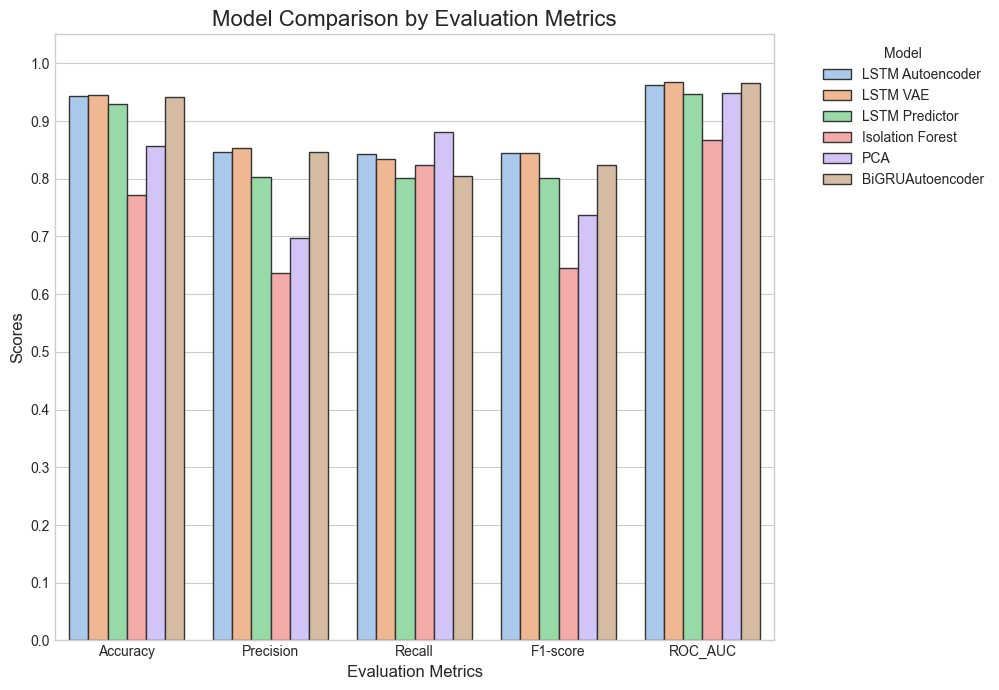

In [13]:
models = ['LSTM Autoencoder', 'LSTM VAE', 'LSTM Predictor',
          'Isolation Forest', 'PCA', 'BiGRUAutoencoder']
accuracy = [0.944, 0.945, 0.929, 0.771, 0.857, 0.941]
precision = [0.846, 0.854, 0.803, 0.636, 0.697, 0.846]
recall = [0.842, 0.835, 0.801, 0.823, 0.881, 0.805]
f1_score = [0.844, 0.844, 0.801, 0.646, 0.737, 0.824]
roc_auc = [0.962, 0.967, 0.947, 0.867, 0.948, 0.965]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']

all_scores = [accuracy, precision, recall, f1_score, roc_auc]

data_list = []
for i, model_name in enumerate(models):
    model_scores = [metric_list[i] for metric_list in all_scores]
    for j, metric_name in enumerate(metric_names):
         data_list.append({'Model': model_name, 'Metric': metric_name, 'Score': model_scores[j]})

df = pd.DataFrame(data_list)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

sns.barplot(data=df, x='Metric', y='Score', hue='Model', palette='pastel', edgecolor='0.2')

plt.title('Model Comparison by Evaluation Metrics', fontsize=16)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(0, 1.05)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

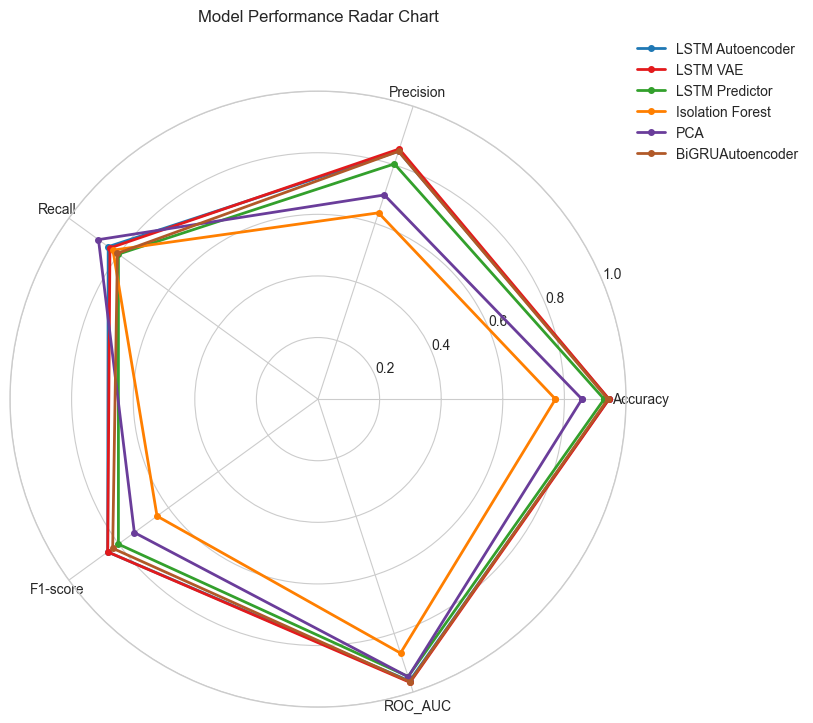

In [12]:
models = ['LSTM Autoencoder', 'LSTM VAE', 'LSTM Predictor',
          'Isolation Forest', 'PCA', 'BiGRUAutoencoder']
accuracy = [0.944, 0.945, 0.929, 0.771, 0.857, 0.941]
precision = [0.846, 0.854, 0.803, 0.636, 0.697, 0.846]
recall = [0.842, 0.835, 0.801, 0.823, 0.881, 0.805]
f1_score = [0.844, 0.844, 0.801, 0.646, 0.737, 0.824]
roc_auc = [0.962, 0.967, 0.947, 0.867, 0.948, 0.965]

scores_by_model = [
    [accuracy[i], precision[i], recall[i], f1_score[i], roc_auc[i]] for i in range(len(models))
]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], metrics)
ax.set_ylim(0, 1)

custom_colors = ['#1f78b4', '#e31a1c', '#33a02c', '#ff7f00', '#6a3d9a', '#b15928']

for i, model_name in enumerate(models):
    scores = np.concatenate((scores_by_model[i],[scores_by_model[i][0]]))
    ax.plot(angles, scores, color=custom_colors[i], linewidth=2, linestyle='-', marker='o', markersize=4, label=model_name)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Model Performance Radar Chart', y=1.1)
plt.show()

 <span style="font-size:18px;font-weight:bold"> Results Analysis </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the evaluation metrics presented, our BiGRU Autoencoder demonstrates highly competitive performance across the board.   While its scores might be slightly lower than the absolute highest achieved by the LSTM Autoencoder or LSTM VAE on certain metrics like F1-score, its performance is remarkably close. Crucially, the BiGRU Autoencoder achieves this near state-of-the-art performance with a potentially simpler architecture compared to complex LSTM or VAE structures.   This balance of strong effectiveness and relative structural simplicity makes the BiGRU Autoencoder a compelling and efficient alternative for tasks like anomaly detection, offering performance comparable to more complex models without necessarily incurring the same computational overhead or implementation complexity.
</span>

<span style="font-size:22px;font-weight:bold"> 9.Conclusion </span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Based on the comparative evaluation across key performance metrics including Accuracy, Precision, Recall, F1-score, and ROC_AUC, it is evident that the sequence-based deep learning models significantly outperform traditional anomaly detection methods like Isolation Forest and PCA for this specific task. Among the deep learning architectures assessed – LSTM Autoencoder, LSTM VAE, LSTM Predictor, and BiGRU Autoencoder – the LSTM Autoencoder and LSTM VAE generally demonstrate the highest scores across several metrics, setting a benchmark for top-tier performance in this comparison. The LSTM Predictor also shows strong results, positioning these recurrent network variants as highly effective solutions for capturing the temporal patterns relevant to the problem.
</span>

<span style="font-size:18px;font-family: 'Times New Roman', Times, serif;">
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Within this competitive landscape, our BiGRU Autoencoder emerges as a particularly compelling model. While its performance metrics are marginally lower than the absolute highest scores achieved by the most complex LSTM variants such as the LSTM Autoencoder or VAE, it consistently achieves results that are remarkably close and highly competitive across all evaluated metrics. Crucially, the BiGRU Autoencoder often accomplishes this near state-of-the-art performance with a less intricate structural design. This inherent simplicity brings practical advantages, including potentially faster training, lower computational resource requirements, and easier implementation and maintenance, presenting the BiGRU Autoencoder as an efficient and robust alternative that strikes an excellent balance between strong detection capabilities and operational practicality.
</span>